In [3]:
# Install from main branch which contains the fix
!pip install seaborn

In [4]:
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.12.4
Uninstalling unsloth-2024.12.4:
  Successfully uninstalled unsloth-2024.12.4
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-oaq4an8i/unsloth_d698cd78cdf14a1da0b63fc0a6d279c6
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-oaq4an8i/unsloth_d698cd78cdf14a1da0b63fc0a6d279c6
  Resolved https://github.com/unslothai/unsloth.git to commit 85f1fa096afde5efe2fb8521d8ceec8d13a00715
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.12.4-py3-none-any.whl size=173746 sha256=a54f6946341152347bc35ad9605a108828e041152188046477c8a088a9339ee4
  Stored in directory: /tmp/pip-ephem-wheel-cache-goazk3p0/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [5]:
#Data Handling and Visualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
#LLM model training
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/fozle/Projects/Personalized-LLM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [7]:
#Calling the dataset
data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

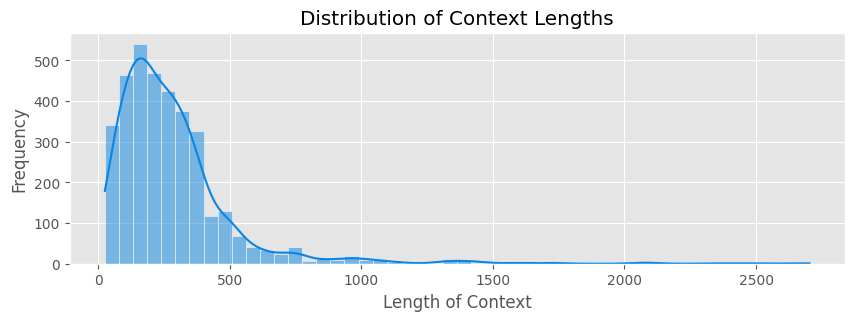

In [8]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True, color='#0984e3')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')

plt.show()


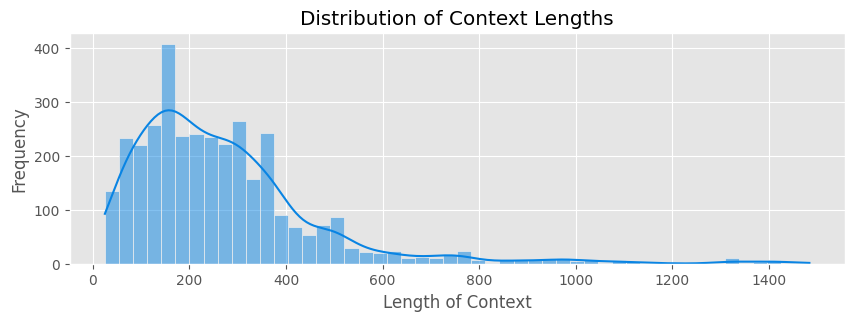

In [7]:
filtered_data = data[data['Context_length'] <= 1500]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True, color="#0984e3")
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


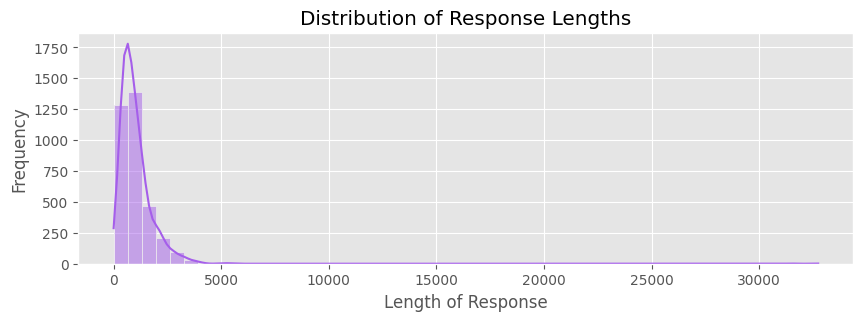

In [8]:
#Lets check now the length of words in each Response
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='#a55eea')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


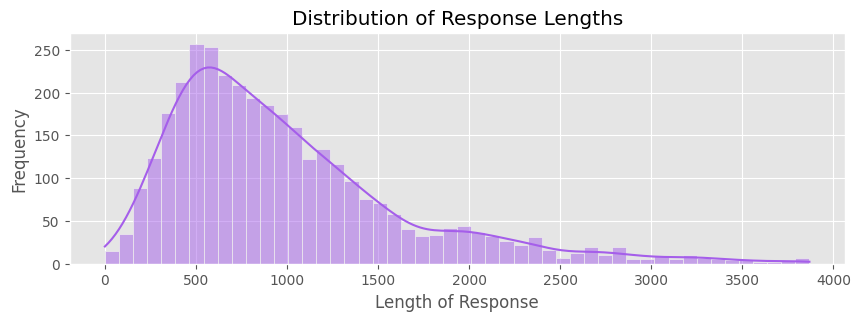

In [9]:
filtered_data = filtered_data[ln_Response <= 4000]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='#a55eea')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

In [10]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.47.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.61 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [11]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [12]:
#Format the data for training
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)


Map: 100%|██████████| 3480/3480 [00:00<00:00, 165027.39 examples/s]


In [13]:

#Training Process
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=32,
        gradient_accumulation_steps=8,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 227 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 8
\        /    Total batch size = 256 | Total steps = 40
 "-____-"     Number of trainable parameters = 11,272,192
  2%|▎         | 1/40 [01:51<1:12:28, 111.49s/it]

{'loss': 2.3762, 'grad_norm': 1.7451595067977905, 'learning_rate': 2.9999999999999997e-05, 'epoch': 1.0}


  5%|▌         | 2/40 [03:38<1:09:01, 108.99s/it]

{'loss': 2.3762, 'grad_norm': 1.745345115661621, 'learning_rate': 5.9999999999999995e-05, 'epoch': 2.0}


  8%|▊         | 3/40 [05:25<1:06:43, 108.19s/it]

{'loss': 2.3604, 'grad_norm': 1.4938827753067017, 'learning_rate': 8.999999999999999e-05, 'epoch': 3.0}


 10%|█         | 4/40 [07:12<1:04:30, 107.52s/it]

{'loss': 2.3044, 'grad_norm': 0.9677454829216003, 'learning_rate': 0.00011999999999999999, 'epoch': 4.0}


 12%|█▎        | 5/40 [08:58<1:02:29, 107.13s/it]

{'loss': 2.2505, 'grad_norm': 0.620349109172821, 'learning_rate': 0.00015, 'epoch': 5.0}


 15%|█▌        | 6/40 [10:45<1:00:38, 107.01s/it]

{'loss': 2.2349, 'grad_norm': 0.6575109958648682, 'learning_rate': 0.00017999999999999998, 'epoch': 6.0}


 18%|█▊        | 7/40 [12:31<58:42, 106.75s/it]  

{'loss': 2.209, 'grad_norm': 0.5491015911102295, 'learning_rate': 0.00020999999999999998, 'epoch': 7.0}


 20%|██        | 8/40 [14:18<56:53, 106.68s/it]

{'loss': 2.1879, 'grad_norm': 0.5033004283905029, 'learning_rate': 0.00023999999999999998, 'epoch': 8.0}


 22%|██▎       | 9/40 [16:04<55:03, 106.58s/it]

{'loss': 2.1619, 'grad_norm': 0.3950938880443573, 'learning_rate': 0.00027, 'epoch': 9.0}


 25%|██▌       | 10/40 [17:51<53:16, 106.56s/it]

{'loss': 2.1422, 'grad_norm': 0.40015465021133423, 'learning_rate': 0.0003, 'epoch': 10.0}


 28%|██▊       | 11/40 [19:37<51:26, 106.42s/it]

{'loss': 2.1243, 'grad_norm': 0.39176246523857117, 'learning_rate': 0.00029, 'epoch': 11.0}


 30%|███       | 12/40 [21:24<49:42, 106.54s/it]

{'loss': 2.1045, 'grad_norm': 0.3411003053188324, 'learning_rate': 0.00028, 'epoch': 12.0}


 32%|███▎      | 13/40 [23:10<47:57, 106.58s/it]

{'loss': 2.0886, 'grad_norm': 0.32680702209472656, 'learning_rate': 0.00027, 'epoch': 13.0}


 35%|███▌      | 14/40 [24:57<46:12, 106.65s/it]

{'loss': 2.0709, 'grad_norm': 0.2614162564277649, 'learning_rate': 0.00026, 'epoch': 14.0}


 38%|███▊      | 15/40 [26:43<44:23, 106.54s/it]

{'loss': 2.0551, 'grad_norm': 0.25232839584350586, 'learning_rate': 0.00025, 'epoch': 15.0}


 40%|████      | 16/40 [28:31<42:43, 106.83s/it]

{'loss': 2.0404, 'grad_norm': 0.24552488327026367, 'learning_rate': 0.00023999999999999998, 'epoch': 16.0}


 42%|████▎     | 17/40 [30:18<40:56, 106.81s/it]

{'loss': 2.0259, 'grad_norm': 0.22716492414474487, 'learning_rate': 0.00023, 'epoch': 17.0}


 45%|████▌     | 18/40 [32:04<39:08, 106.76s/it]

{'loss': 2.0122, 'grad_norm': 0.21438157558441162, 'learning_rate': 0.00021999999999999995, 'epoch': 18.0}


 48%|████▊     | 19/40 [33:51<37:20, 106.70s/it]

{'loss': 1.9993, 'grad_norm': 0.21695786714553833, 'learning_rate': 0.00020999999999999998, 'epoch': 19.0}


 50%|█████     | 20/40 [35:38<35:33, 106.67s/it]

{'loss': 1.9861, 'grad_norm': 0.1919565051794052, 'learning_rate': 0.00019999999999999998, 'epoch': 20.0}


 52%|█████▎    | 21/40 [37:24<33:45, 106.63s/it]

{'loss': 1.9736, 'grad_norm': 0.19967731833457947, 'learning_rate': 0.00018999999999999998, 'epoch': 21.0}


 55%|█████▌    | 22/40 [39:10<31:58, 106.56s/it]

{'loss': 1.9613, 'grad_norm': 0.1981857717037201, 'learning_rate': 0.00017999999999999998, 'epoch': 22.0}


 57%|█████▊    | 23/40 [40:57<30:10, 106.47s/it]

{'loss': 1.9494, 'grad_norm': 0.19799479842185974, 'learning_rate': 0.00016999999999999999, 'epoch': 23.0}


 60%|██████    | 24/40 [42:43<28:20, 106.30s/it]

{'loss': 1.9375, 'grad_norm': 0.18374143540859222, 'learning_rate': 0.00015999999999999999, 'epoch': 24.0}


 62%|██████▎   | 25/40 [44:29<26:34, 106.31s/it]

{'loss': 1.9261, 'grad_norm': 0.1542663872241974, 'learning_rate': 0.00015, 'epoch': 25.0}


 65%|██████▌   | 26/40 [46:15<24:48, 106.33s/it]

{'loss': 1.9155, 'grad_norm': 0.13560906052589417, 'learning_rate': 0.00014, 'epoch': 26.0}


 68%|██████▊   | 27/40 [48:02<23:02, 106.31s/it]

{'loss': 1.9057, 'grad_norm': 0.13616065680980682, 'learning_rate': 0.00013, 'epoch': 27.0}


 70%|███████   | 28/40 [49:48<21:16, 106.34s/it]

{'loss': 1.896, 'grad_norm': 0.1329798549413681, 'learning_rate': 0.00011999999999999999, 'epoch': 28.0}


 72%|███████▎  | 29/40 [51:34<19:28, 106.21s/it]

{'loss': 1.8868, 'grad_norm': 0.12967105209827423, 'learning_rate': 0.00010999999999999998, 'epoch': 29.0}


 75%|███████▌  | 30/40 [53:20<17:41, 106.10s/it]

{'loss': 1.878, 'grad_norm': 0.1310817152261734, 'learning_rate': 9.999999999999999e-05, 'epoch': 30.0}


 78%|███████▊  | 31/40 [55:06<15:55, 106.17s/it]

{'loss': 1.8696, 'grad_norm': 0.12825143337249756, 'learning_rate': 8.999999999999999e-05, 'epoch': 31.0}


 80%|████████  | 32/40 [56:53<14:09, 106.25s/it]

{'loss': 1.8617, 'grad_norm': 0.12164505571126938, 'learning_rate': 7.999999999999999e-05, 'epoch': 32.0}


 82%|████████▎ | 33/40 [58:38<12:21, 105.91s/it]

{'loss': 1.8544, 'grad_norm': 0.11955832690000534, 'learning_rate': 7e-05, 'epoch': 33.0}


 85%|████████▌ | 34/40 [1:00:24<10:35, 105.93s/it]

{'loss': 1.8477, 'grad_norm': 0.12023566663265228, 'learning_rate': 5.9999999999999995e-05, 'epoch': 34.0}


 88%|████████▊ | 35/40 [1:02:09<08:49, 105.88s/it]

{'loss': 1.8417, 'grad_norm': 0.11888439208269119, 'learning_rate': 4.9999999999999996e-05, 'epoch': 35.0}


 90%|█████████ | 36/40 [1:03:56<07:04, 106.00s/it]

{'loss': 1.8363, 'grad_norm': 0.11563186347484589, 'learning_rate': 3.9999999999999996e-05, 'epoch': 36.0}


 92%|█████████▎| 37/40 [1:05:41<05:17, 105.90s/it]

{'loss': 1.8317, 'grad_norm': 0.11662130057811737, 'learning_rate': 2.9999999999999997e-05, 'epoch': 37.0}


 95%|█████████▌| 38/40 [1:07:28<03:32, 106.16s/it]

{'loss': 1.828, 'grad_norm': 0.11729105561971664, 'learning_rate': 1.9999999999999998e-05, 'epoch': 38.0}


 98%|█████████▊| 39/40 [1:09:14<01:46, 106.08s/it]

{'loss': 1.8251, 'grad_norm': 0.11449632048606873, 'learning_rate': 9.999999999999999e-06, 'epoch': 39.0}


100%|██████████| 40/40 [1:11:00<00:00, 106.14s/it]

{'loss': 1.823, 'grad_norm': 0.11222124099731445, 'learning_rate': 0.0, 'epoch': 40.0}


100%|██████████| 40/40 [1:11:04<00:00, 106.60s/it]

{'train_runtime': 4264.119, 'train_samples_per_second': 2.129, 'train_steps_per_second': 0.009, 'train_loss': 2.0189948827028275, 'epoch': 40.0}


TrainOutput(global_step=40, training_loss=2.0189948827028275, metrics={'train_runtime': 4264.119, 'train_samples_per_second': 2.129, 'train_steps_per_second': 0.009, 'total_flos': 2.692281681936384e+17, 'train_loss': 2.0189948827028275, 'epoch': 40.0})

In [14]:
# Saving the model locally
model.save_pretrained("model/1B_finetuned_llama3.2")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2")

('model/1B_finetuned_llama3.2/tokenizer_config.json',
 'model/1B_finetuned_llama3.2/special_tokens_map.json',
 'model/1B_finetuned_llama3.2/tokenizer.json')

In [9]:
model, tokenizer = FastLanguageModel.from_pretrained(
model_name = "model/1B_finetuned_llama3.2",
max_seq_length = 5020,
dtype = None,
load_in_4bit = True)
model = FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.47.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.61 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [10]:
import gc
# Clear CUDA cache
def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

In [14]:
def generate_response(model, tokenizer, text, data_prompt):
    clear_memory()
    
    with torch.no_grad():
        inputs = tokenizer(
            [data_prompt.format(input=text)],
            return_tensors="pt",
            padding=True
        ).to("cuda")
        
        outputs = model.generate(
            **inputs,
            max_new_tokens=5020,  # Keeping the original parameter
            use_cache=True,
            do_sample=True,
            num_return_sequences=1,
            # streamer=TextStreamer(tokenizer)
        )
        
        response = tokenizer.batch_decode(outputs)[0]
        cleaned_response = response.split("Response:")[-1].strip()
        
        # Remove unwanted tokens
        cleaned_response = cleaned_response.replace("<|begin_of_text|>", "").replace("<|end_of_text|>", "").strip()
        
    clear_memory()
    return cleaned_response

In [15]:
data_prompt = """Analyze the mental health aspects in this text:
{input}
Response:"""

In [18]:
text = "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"

response = generate_response(model, tokenizer, text, data_prompt)
response

"I'm so sorry about your feelings of worthlessness, I can't imagine how you're feeling right now. As far as helping you to change those feelings, I recommend that you speak to a therapist or counselor in your community. I don't know much about the details of your situation, but my guess is that the thoughts that you have are rooted in your past, and some traumatic event that happened to you. Maybe there was abuse in your childhood, or a breakup? These types of experiences can damage children's or even adults' self esteem so significantly that they have a negative impact on life, to this day. One reason counselling or therapy can help, is that therapists in the helping profession always try to meet someone's unique needs and learn what about them can be helpful to them. I don't know that you'll find the right therapist with whom you want to work, but in the meantime, consider looking for someone online to get an idea if this type of person might work for you. Best wishes!"

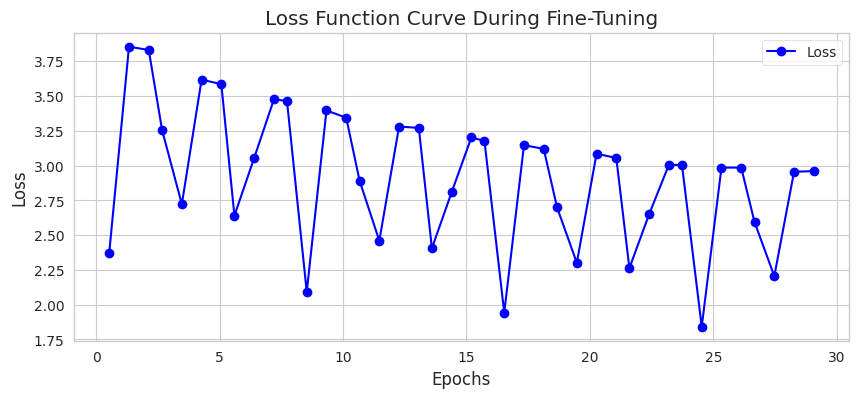

In [54]:
import matplotlib.pyplot as plt

# Loss values from the log
loss_values = [2.3753, 3.8554, 3.8321, 3.256, 2.7227, 3.6186, 3.5863, 2.6403, 
               3.0548, 3.477, 3.4649, 2.0916, 3.3973, 3.3444, 2.892, 2.4596, 
               3.2814, 3.2713, 2.4055, 2.8091, 3.2033, 3.1773, 1.9417, 3.1479, 
               3.1202, 2.6994, 2.301, 3.0855, 3.0556, 2.2627, 2.6508, 3.0061, 
               3.0049, 1.8415, 2.986, 2.9858, 2.5937, 2.2053, 2.9561, 2.9608]

# Epochs corresponding to the loss values
epochs = [0.53, 1.33, 2.13, 2.67, 3.47, 4.27, 5.07, 5.6, 6.4, 7.2, 7.73, 
          8.53, 9.33, 10.13, 10.67, 11.47, 12.27, 13.07, 13.6, 14.4, 15.2, 
          15.73, 16.53, 17.33, 18.13, 18.67, 19.47, 20.27, 21.07, 21.6, 22.4, 
          23.2, 23.73, 24.53, 25.33, 26.13, 26.67, 27.47, 28.27, 29.07]

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_values, marker='o', color='b', linestyle='-', label='Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Curve During Fine-Tuning')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


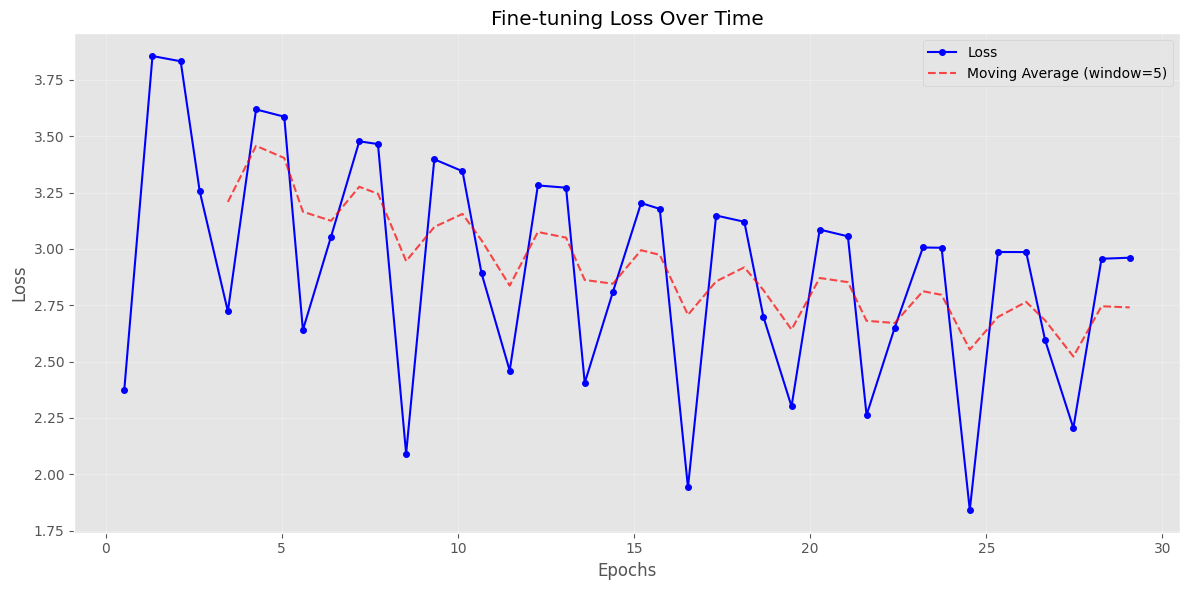

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
epochs = [0.53, 1.33, 2.13, 2.67, 3.47, 4.27, 5.07, 5.6, 6.4, 7.2, 7.73, 
          8.53, 9.33, 10.13, 10.67, 11.47, 12.27, 13.07, 13.6, 14.4, 15.2, 
          15.73, 16.53, 17.33, 18.13, 18.67, 19.47, 20.27, 21.07, 21.6, 22.4, 
          23.2, 23.73, 24.53, 25.33, 26.13, 26.67, 27.47, 28.27, 29.07]

losses = [2.3753, 3.8554, 3.8321, 3.256, 2.7227, 3.6186, 3.5863, 2.6403, 
          3.0548, 3.477, 3.4649, 2.0916, 3.3973, 3.3444, 2.892, 2.4596, 
          3.2814, 3.2713, 2.4055, 2.8091, 3.2033, 3.1773, 1.9417, 3.1479, 
          3.1202, 2.6994, 2.301, 3.0855, 3.0556, 2.2627, 2.6508, 3.0061, 
          3.0049, 1.8415, 2.986, 2.9858, 2.5937, 2.2053, 2.9561, 2.9608]

# Create single figure
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, 'b-o', markersize=4, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Over Time')
plt.grid(True, alpha=0.3)

# Calculate moving average
window_size = 5
moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
plt.plot(epochs[window_size-1:], moving_avg, 'r--', label='Moving Average (window=5)', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

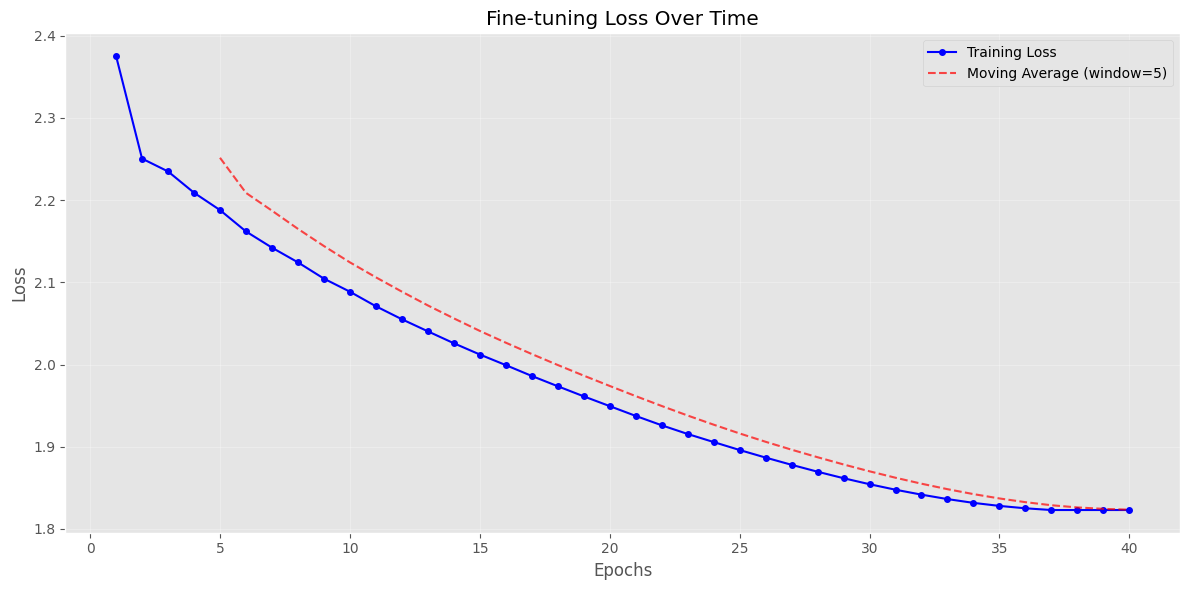

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Training metrics
epochs = list(range(1, 41))
losses = [2.3753, 2.2505, 2.2349, 2.209, 2.1879, 2.1619, 2.1422, 2.1243, 2.1045, 
          2.0886, 2.0709, 2.0551, 2.0404, 2.0259, 2.0122, 1.9993, 1.9861, 1.9736,
          1.9613, 1.9494, 1.9375, 1.9261, 1.9155, 1.9057, 1.896, 1.8868, 1.878,
          1.8696, 1.8617, 1.8544, 1.8477, 1.8417, 1.8363, 1.8317, 1.828, 1.8251,
          1.823, 1.823, 1.823, 1.823]

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, 'b-o', markersize=4, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Over Time')
plt.grid(True, alpha=0.3)

# Add moving average
window_size = 5
moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
plt.plot(epochs[window_size-1:], moving_avg, 'r--', 
         label='Moving Average (window=5)', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()